In [132]:
from DiscEvolution.grid import Grid
from DiscEvolution.star import SimpleStar
from DiscEvolution.dust import DustGrowthTwoPop, SingleFluidDrift, FixedSizeDust
from DiscEvolution.eos import SimpleDiscEOS, ChambersEOS, LocallyIsothermalEOS, IrradiatedEOS
from DiscEvolution.viscous_evolution import LBP_Solution, ViscousEvolutionFV, ViscousEvolution
from DiscEvolution.disc_winds import DiskWindEvolution
from DiscEvolution.planet_formation import *
from DiscEvolution.constants import Msun, AU, yr, Mearth

import numpy as np
import matplotlib.pyplot as plt
import copy

%config InlineBackend.figure_format = 'svg'

In [133]:
def chambers_model(param_type = "Chambers", **kwargs):

    init_params = {"sigma0":3450,
                "r0":1, 
                "T0":150, 
                "v0":30,
                "fw":0,
                "K":0, 
                "alpha_turb":0,
                "alpha_wind":0,
                "Tevap":1500, 
                "rexp":15,
                "k0":0.1,
                "rmin":0.05,
                "rmax":1000,
                "nr":1000,
                "initial_frac":0.01,
                "fixed_size":False,
                "init_conditions": False}
    
    alpha_turb = init_params['alpha_turb']

    init_params.update(kwargs)

    grid = Grid(init_params['rmin'], init_params['rmax'], init_params['nr'])
    star = SimpleStar()
    wind = DiskWindEvolution(star, init_params['sigma0'],init_params['r0'],init_params['T0'],
                            init_params['v0'],init_params['fw'],
                            init_params['K'],init_params['Tevap'],
                            init_params['rexp'],init_params['k0'])
    
    eos = ChambersEOS(star, init_params['sigma0'],init_params['r0'],init_params['T0'],
                            init_params['v0'],init_params['fw'],
                            init_params['K'],init_params['Tevap'],
                            init_params['rexp'],init_params['k0'])

    if param_type == "Suzuki":
        wind.calculate_chambers_params(init_params['alpha_turb'], init_params['alpha_wind'], set=True)
        # eos = LocallyIsothermalEOS(star, 1/30., -0.25, init_params['alpha_turb'])
        eos.update_params(wind)
    else:
        print("penis", alpha_turb)

    eos.set_grid(grid)
    
    Sigma = wind(grid.Rc, 0)
    Mdot = wind.M_acc
    Mtot = wind.M_tot
    disc = DustGrowthTwoPop(grid, star, eos, 0.01, Sigma)


    return disc, grid, eos, wind

In [134]:
def LBP_model(**kwargs):

    init_params = {"alpha":1e-3, "rmin":0.05, "rmax":1000, "nr":1000, "Mdot":1e-8}
    init_params.update(kwargs)

    alpha = init_params['alpha']

    grid = Grid(init_params['rmin'], init_params['rmax'], init_params['nr'])
    star = SimpleStar()

    Mdot  = init_params["Mdot"]
    Rd    = 30
    R = grid.Rc
    Mdot *= (Msun / yr) / AU**2
    Sigma = (Mdot / (0.1 * alpha * R**2 * star.Omega_k(R))) * np.exp(-R/Rd)

    eos = SimpleDiscEOS(star, alpha)    
    eos.set_grid(grid)
    eos.update(0, Sigma)
    for i in range(100):
        Sigma = 0.5 * (Sigma + (Mdot / (3 * np.pi * eos.nu)) * np.exp(-R/Rd))
        eos.update(0, Sigma)

    gas = ViscousEvolutionFV()
    
    disc = DustGrowthTwoPop(grid, star, eos, 0.01, Sigma)
    
    v_visc = gas.viscous_velocity(disc, Sigma)
    Mdot = disc.Mdot(v_visc)[0]
    Mtot = disc.Mtot()/Msun

    return disc, grid, eos, gas, Mdot, Mtot

<>:26: SyntaxWarning: invalid escape sequence '\S'
<>:26: SyntaxWarning: invalid escape sequence '\S'
/var/folders/80/3_r0dytx0g58z7ybrd36jc_40000gn/T/ipykernel_37099/1384272318.py:26: SyntaxWarning: invalid escape sequence '\S'
  ax[0].set_ylabel("Surface density $\Sigma_g$ [g cm$^{-3}$]", size=13)
/Users/safwankhan/Library/CloudStorage/OneDrive-UniversityofWaterloo/University/Research/Planet Formation/DiscEvolution/DiscEvolution/eos.py:222: RuntimeWarning: divide by zero encountered in divide
  return 1. / Pr_1


Chambers accretion rate: 9.845018192747528e-09 Msun/yr. Total mass: 0.03909089479067191 Msun
LBP accretion rate: 2.454895851608075e-09 Msun/yr. Total mass: 0.039175412146790274 Msun


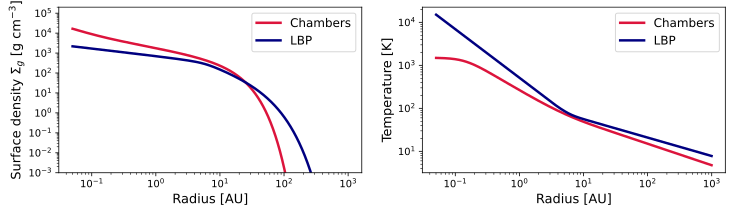

In [165]:
disc_C, grid_C, eos_C, gas_C = chambers_model(param_type="Suzuki", sigma0=1850, alpha_turb=1e-3, alpha_wind=0)
# disc_C, grid_C, eos_C, gas_C = chambers_model(sigma0=850, alpha_turb=1e-3, alpha_wind=2.5e-4, K=0.1)
# disc_C, grid_C, eos_C, gas_C = chambers_model(sigma0=1500, fw=0.89, K=0.1, v0=24)

disc_LBP, grid_LBP, eos_LBP, gas_LBP, Mdot_LBP, Mtot_LBP = LBP_model(alpha=1e-3, Mdot=1e-8)

Mdot_C = gas_C.M_acc
Mtot_C = gas_C.M_tot

Sigma_LBP = disc_LBP.Sigma_G
Rc_LBP = grid_LBP.Rc
T_LBP = disc_LBP.T

Sigma_C = disc_C.Sigma_G

T_C = disc_C.T
Rc_C = grid_C.Rc

fig, ax = plt.subplots(1,2, figsize = (12,3))

linewidth = 2.5
ax[0].loglog(Rc_C, Sigma_C, label = "Chambers", color = "Crimson", linewidth = linewidth)
ax[0].loglog(Rc_LBP, Sigma_LBP, label = "LBP", color = "navy", linewidth = linewidth)
ax[0].set_ylim(1e-3, 2e5)
ax[0].set_xlabel("Radius [AU]", size=13)
ax[0].set_ylabel("Surface density $\Sigma_g$ [g cm$^{-3}$]", size=13)
ax[0].legend(fontsize = 12)

ax[1].loglog(Rc_C, T_C, label = "Chambers", color = "crimson", linewidth = linewidth)
ax[1].loglog(Rc_LBP, T_LBP, label = "LBP", color = "navy", linewidth = linewidth)
ax[1].set_xlabel("Radius [AU]", size=13)
ax[1].set_ylabel("Temperature [K]", size=13)
ax[1].legend(fontsize = 12)

print("Chambers accretion rate:", Mdot_C, "Msun/yr.", "Total mass:", Mtot_C, "Msun")
print("LBP accretion rate:", Mdot_LBP, "Msun/yr.", "Total mass:", Mtot_LBP, "Msun")
plt.savefig("/Users/safwankhan/Library/CloudStorage/OneDrive-UniversityofWaterloo/University/4B/PHYS 437B/Presentation/figures/LBP_chambers_comparison.pdf", bbox_inches="tight")

In [136]:
# disc, grid, eos, wind, Mdot, Mtot = chambers_model(sigma0=1850, alpha_turb=1e-3, alpha_wind=0)
# dust = SingleFluidDrift()
# gas = ViscousEvolution()
# planets = Planets(Nchem = 0)
# planets.add_planet(0, 30, 0.1, 0)
# planet_model = Bitsch2015Model(disc, pb_gas_f=0.0)

# fig, ax = plt.subplots(1,2, figsize = (11,5))
# colours = ["crimson", "sandybrown", "darkseagreen", "navy", "deeppink", "darkorange"]
# times = np.array([0, 1e4, 1e5, 1e6, 3e6])*2*np.pi
# t = 0
# n = 0
# n2 = 0

# core_mass = []
# env_mass = []
# dist = []
# ts = []

# for ti in times:
#     while t < ti:
#         v_visc = gas.viscous_velocity(disc)
#         dt = dust.max_timestep(disc)
#         dti = min(dt, ti - t)

#         t = min(t + dt, ti)
#         n += 1

#         sigma_new = wind(grid.Rc, t/(2*np.pi))
#         disc.set_surface_density(sigma_new)

#         dust(dt, disc)

#         # planet_model.update()
#         # planet_model.integrate(dt, planets)

#         disc.update(dt)

#         core_mass.append(planets.M_core)
#         env_mass.append(planets.M_env)
#         dist.append(planets.R)
#         ts.append(ti/(2*np.pi))

#         if (n % 1000) == 0:
#             print('Nstep: {}'.format(n))
#             print('Time: {} yr'.format(t / (2 * np.pi)))
#             print('dt: {} yr'.format(dti / (2 * np.pi)))

#     ax[0].loglog(grid.Rc, disc.Sigma, color = colours[n2])
#     ax[0].loglog(grid.Rc, disc.Sigma_D[0]+disc.Sigma_D[1], color = colours[n2], linestyle = "--")
#     ax[0].set_ylim(1e-3, 2e5)
#     ax[0].set_xlabel("Radius [AU]")
#     ax[0].set_ylabel("Surface density [g cm$^{-3}$]")
    
#     # ax[1].loglog(grid.Rc, disc.T, color = colours[n2])
#     # ax[1].set_ylim(10, 2e3)
#     # ax[1].set_xlabel("Radius [AU]")
#     # ax[1].set_ylabel("Temperature [K]")
#     n2+=1

# ax[1].loglog(ts, core_mass, label="core mass", color = "crimson")
# ax[1].loglog(ts, env_mass, label="envelope mass", color = "navy")
# ax[1].set_xlabel("Time [yr]")
# ax[1].set_ylabel("Mass [$M_{earth}$]")
# ax2 = ax[1].twinx()
# ax2.loglog(ts, dist, label = "position", color = "darkseagreen", linestyle = "--")
# ax2.set_ylabel("Distance [AU]")
# ax[1].legend()

# plt.show()

In [137]:
def evolve(disc, gas, timesteps=[1e6], print_time = False, grow_planet = False):
    dust = SingleFluidDrift()
    planets = Planets()
    planets.add_planet(0, 1, 0.001, 0)
    planet_model = Bitsch2015Model(disc)
    discs = []
    
    times = timesteps*2*np.pi
    t=0
    n=0
    for ti in times:
        while t < ti:
            dt = dust.max_timestep(disc)
            dti = min(dt, ti - t)
            t = min(t + dt, ti)

            sigma = gas(grid.Rc, t/(2*np.pi))
            disc.set_surface_density(sigma)
            
            dust(dti, disc)

            if grow_planet:
                planet_model.integrate(dt, planets)

            disc.update(dt)

            n+=1

            if print_time:
                if (n % 1000) == 0:
                    print('Nstep: {}'.format(n))
                    print('Time: {} yr'.format(t / (2 * np.pi)))
                    print('dt: {} yr'.format(dti / (2 * np.pi)))

        # return an array of disks at each time step
        discs.append(copy.deepcopy(disc))
    
    if grow_planet:
        return discs, planets
    else:
        return discs

fixed = False
timesteps = np.array([0.01, 0.1, 1, 2, 3])*1e6
disc, grid, eos, gas = chambers_model(param_type="Suzuki", sigma0=1850, alpha_turb=1e-3)
# disc, grid, eos, gas = chambers_model(sigma0=850, alpha_turb=1e-3, alpha_wind=0, fixed_size = fixed)
# disc, grid, eos, gas = chambers_model(sigma0=1500, alpha_turb=1e-3, alpha_wind=2.5e-4, fw=0.89, K=0.1, v0=24, fixed_size = fixed)
# disc, grid, eos, gas, Mdot, Mtot = LBP_model(alpha=1e-3, Mdot=1e-8)
discs = evolve(disc, gas, timesteps = timesteps, print_time=True)
# discs, planets = evolve(disc, gas, timesteps = timesteps, print_time=True, grow_planet=True)

Nstep: 1000
Time: 2612.7062712638203 yr
dt: 2.616898532462422 yr
Nstep: 2000
Time: 5238.030025889927 yr
dt: 2.63053146710861 yr
Nstep: 3000
Time: 7837.755157313933 yr
dt: 2.4470631381169667 yr
Nstep: 4000
Time: 9668.503688812378 yr
dt: 1.5733171757094162 yr
Nstep: 5000
Time: 11025.259212621791 yr
dt: 1.4346924760022004 yr
Nstep: 6000
Time: 12305.824006622131 yr
dt: 1.3200274818743192 yr
Nstep: 7000
Time: 13465.974004699605 yr
dt: 1.1880386080548206 yr
Nstep: 8000
Time: 14528.712625649863 yr
dt: 1.087173542200145 yr
Nstep: 9000
Time: 15525.645298955727 yr
dt: 1.0396167324575978 yr
Nstep: 10000
Time: 16528.54113049556 yr
dt: 1.0436938199960437 yr
Nstep: 11000
Time: 17546.937523300956 yr
dt: 0.996317248849131 yr
Nstep: 12000
Time: 18583.548699189123 yr
dt: 1.0732423244121323 yr
Nstep: 13000
Time: 19605.44493898552 yr
dt: 1.0229117637891816 yr
Nstep: 14000
Time: 20600.235466097834 yr
dt: 0.9605329974650553 yr
Nstep: 15000
Time: 21566.676976841558 yr
dt: 0.981414583779251 yr
Nstep: 16000
Ti

/var/folders/80/3_r0dytx0g58z7ybrd36jc_40000gn/T/ipykernel_37099/4059838562.py:34: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim(0, 200)


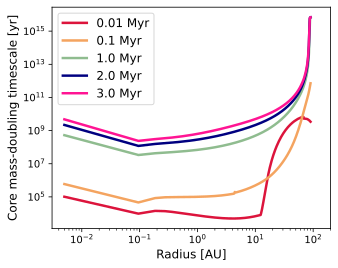

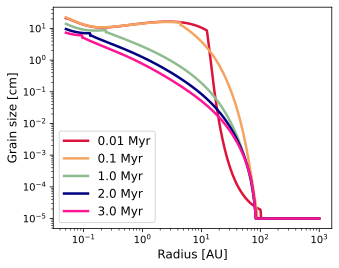

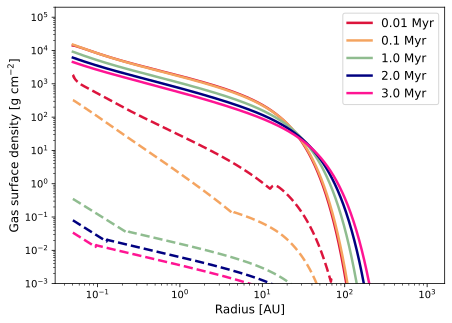

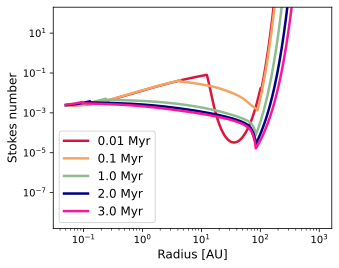

In [166]:
R = np.linspace(0.005, 90, 1000)

fig, ax = plt.subplots(1,1, figsize = (5,4))
fig2, ax2 = plt.subplots(1,1, figsize = (5,4))
# fig3, ax3 = plt.subplots(1,1, figsize = (8,6))
fig4, ax4 = plt.subplots(1,1, figsize = (7,5))
fig5, ax5 = plt.subplots(1,1, figsize = (5,4))
t0 = 2*np.pi
M = 0.1
i=0
colours = ["crimson", "sandybrown", "darkseagreen", "navy", "deeppink", "darkorange"]
for disc, t in zip(discs, timesteps):
    times = []
    Rs = []
    for R_p in R:
        planets = Planets(Nchem = 0)
        planets.add_planet(t, R_p, M, 0.001)
        PebAcc = PebbleAccretionHill(disc)
        M_dot = PebAcc(planets)

        M_core = M
        core_time = M_core/M_dot[0]/t0

        times.append(core_time)
        Rs.append(R_p)

    ax5.loglog(disc.R, disc.Stokes()[1], label = f"{t/1e6} Myr", color = colours[i], linewidth = linewidth)
    ax4.loglog(disc.R, disc.Sigma_G, label = f"{t/1e6} Myr", color = colours[i], linewidth = linewidth)
    ax4.loglog(disc.R, disc.Sigma_D[1], color = colours[i], linestyle = "--", linewidth = linewidth)
    ax2.loglog(disc.R, disc.grain_size[1], label = f"{t/1e6} Myr", color = colours[i], linewidth = linewidth)
    ax.loglog(R, times, label=f"{t/1e6} Myr", color = colours[i], linewidth = linewidth)
    i+=1
    
ax.set_xlim(0, 200)
ax.set_xlabel("Radius [AU]", size = 12)
ax.set_ylabel("Core mass-doubling timescale [yr]", size = 12)
ax.legend(fontsize = 12)

# ax2.set_xlim(0, 200)
# ax2.set_ylim(1e-12, 10)
ax2.set_xlabel("Radius [AU]", size = 12)
ax2.set_ylabel("Grain size [cm]", size = 12)
ax2.legend(fontsize = 12)

# ax3.set_xlabel("Radius [AU]")
# ax3.set_ylabel(r"Dust surface density [g cm$^{2}$]")
# ax3.set_ylim(1e-5, 2e5)
# ax3.legend()

ax4.set_xlabel("Radius [AU]", size = 12)
ax4.set_ylabel(r"Gas surface density [g cm$^{-2}$]", size = 12)
ax4.set_ylim(1e-3, 2e5)
ax4.legend(fontsize = 12)

ax5.set_xlabel("Radius [AU]", size = 12)
ax5.set_ylabel("Stokes number", size = 12)
ax5.set_ylim(top=2e2)
ax5.legend(fontsize = 12)

In [ ]:
fig.savefig("/Users/safwankhan/Library/CloudStorage/OneDrive-UniversityofWaterloo/University/4B/PHYS 437B/Presentation/figures/planet_growth_timescales.pdf", bbox_inches="tight")
fig4.savefig("/Users/safwankhan/Library/CloudStorage/OneDrive-UniversityofWaterloo/University/4B/PHYS 437B/Presentation/figures/viscous_disk.pdf", bbox_inches="tight")
fig5.savefig("/Users/safwankhan/Library/CloudStorage/OneDrive-UniversityofWaterloo/University/4B/PHYS 437B/Presentation/figures/stokes_numbers.pdf", bbox_inches="tight")
fig2.savefig("/Users/safwankhan/Library/CloudStorage/OneDrive-UniversityofWaterloo/University/4B/PHYS 437B/Presentation/figures/pebble_size.pdf", bbox_inches="tight")

In [140]:
disc, grid, eos, wind, Mdot, Mtot = chambers_model(sigma0=1850, alpha_turb=1e-3, alpha_wind=0, fixed_size = fixed)
dust = SingleFluidDrift()
t_stop = 3e6
times = np.array([0, 1e4, 1e5, t_stop])*2*np.pi
min_locs = []
timestamps = []

t=0
t0 = 2*np.pi
n=0
M_core = 0.1
planets = Planets(Nchem = 0)
Rps = np.linspace(0.005, 90, 1000)
for Rp in Rps:
    planets.add_planet(t_stop, Rp, M_core, 0.001)
PebAcc = PebbleAccretionHill(disc)
Mdot = PebAcc(planets)

for ti in times:
    while t < ti:
        dt = dust.max_timestep(disc)
        dti = min(dt, ti - t)
        t = min(t + dt, ti)

        sigma = wind(grid.Rc, t/t0)
        disc.set_surface_density(sigma)

        Mdot = PebAcc(planets)
        core_time = M_core/Mdot/t0
        min_index = np.argmin(core_time)
        min_locs.append(planets.R[min_index])
        timestamps.append(t/t0)
        
        dust(dti, disc)
        disc.update(dt)

        n+=1

        if (n % 1000) == 0:
            print('Nstep: {}'.format(n))
            print('Time: {} yr'.format(t / (2 * np.pi)))
            print('dt: {} yr'.format(dti / (2 * np.pi)))

mass = disc.Mdust()

fig, ax = plt.subplots(1,1)
ax.loglog(timestamps, min_locs)

penis 0


ValueError: not enough values to unpack (expected 6, got 4)

/var/folders/80/3_r0dytx0g58z7ybrd36jc_40000gn/T/ipykernel_42958/1597567619.py:66: RuntimeWarning: divide by zero encountered in divide
  l, = plt.loglog(M_p, M_p/PebAcc(planets)/t0)
/Users/safwankhan/Library/CloudStorage/OneDrive-UniversityofWaterloo/University/Research/Planet Formation/DiscEvolution/DiscEvolution/planet_formation.py:162: RuntimeWarning: divide by zero encountered in divide
  Mdot_PY = self._fPiso * T81**-0.5 * M_core**(11/3.) / M_env


Dust mass: 69.47740468154815
[ 0.5  5.  50. ]
[0.01255741 0.01423654 0.01940115]
[0. 0. 0.]


/Users/safwankhan/Library/CloudStorage/OneDrive-UniversityofWaterloo/University/Research/Planet Formation/DiscEvolution/DiscEvolution/planet_formation.py:429: RuntimeWarning: invalid value encountered in sqrt
  x = (1.1 / g_eff**0.25) * np.sqrt(q_h)
/Users/safwankhan/Library/CloudStorage/OneDrive-UniversityofWaterloo/University/Research/Planet Formation/DiscEvolution/DiscEvolution/star.py:57: RuntimeWarning: invalid value encountered in power
  return R * (M / (3*self._M))**(1/3.)
/Users/safwankhan/Library/CloudStorage/OneDrive-UniversityofWaterloo/University/Research/Planet Formation/DiscEvolution/DiscEvolution/star.py:48: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self._M / r)
/Users/safwankhan/Library/CloudStorage/OneDrive-UniversityofWaterloo/University/Research/Planet Formation/DiscEvolution/DiscEvolution/planet_formation.py:403: RuntimeWarning: invalid value encountered in log
  lgR = np.log(Rp)
/Users/safwankhan/Library/CloudStorage/OneDrive-UniversityofW

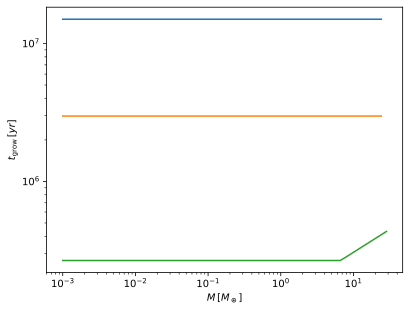

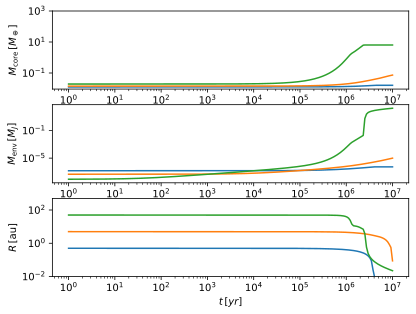

In [ ]:
GM = 1.
cs0 = (1/30.) 
q = -0.25
Mdot = 1e-8
alpha = 1e-3

Mdot *= Msun / (2*np.pi)
Mdot /= AU**2

Rin = 0.01
Rout = 5e2
Rd = 100.

t0 = (2*np.pi)

star = SimpleStar()


grid = Grid(0.01, 1000, 1000, spacing='log')
eos = LocallyIsothermalEOS(star, cs0, q, alpha)
eos.set_grid(grid)
Sigma =  (Mdot / (3 * np.pi * eos.nu))*np.exp(-grid.Rc/Rd)
if 1:
    eos = IrradiatedEOS(star, alpha, tol=1e-3, accrete=False)     
    eos.set_grid(grid)
    eos.update(0, Sigma)
    
    # Now do a new guess for the surface density and initial eos.
    Sigma = (Mdot / (3 * np.pi * eos.nu))*np.exp(-grid.Rc/Rd)

    eos = IrradiatedEOS(star, alpha, tol=1e-3)
    eos.set_grid(grid)
    eos.update(0, Sigma)
    
# Sigma = disc.Sigma
# print(np.mean(Sigma))
disc = FixedSizeDust(grid, star, eos, 1e-3, 1, Sigma)
R = disc.R


#######
# Test the migration rate calculation
Rp = [1,5,25,100]
M_p = np.logspace(-3, 4.0, 100)

planets = Planets()
for Mi in M_p:
    planets.add_planet(0, 1, Mi, 0)
#######
# Test the growth models

# Set up some planet mass / envelope ratios
#M_p = planets.M
planets.M_core = np.minimum(20, 0.9*M_p)
planets.M_env  = M_p - planets.M_core


#Sigma = 1700 * R**-1.5
Rp = [0.5, 5., 50.]

PebAcc = PebbleAccretionHill(disc)
GasAcc = GasAccretion(disc)
plt.figure()
for Ri in Rp:
    planets.R[:] = Ri
    l, = plt.loglog(M_p, M_p/PebAcc(planets)/t0)
    # plt.loglog(M_p, M_p/GasAcc(planets)/t0,
    #             c=l.get_color(), ls='--')
print("Dust mass:", disc.Mdust()/Mearth)

plt.xlabel(r'$M\,[M_\oplus]$')
plt.ylabel(r'$t_\mathrm{grow}\,[yr]$')

# Growth tracks
plt.figure()

planet_model = Bitsch2015Model(disc, pb_gas_f=0.0)

times = np.logspace(0, 7, 200)
Rp  = np.array(Rp)

planets = Planets()
for Ri in Rp:
    planet_model.insert_new_planet(0, Ri, planets)

print(planets.R)
print(planets.M_core)
print(planets.M_env)
    
Rs, Mcs, Mes, = [], [], []
t = 0
for ti in times:
    ti *= t0
    planet_model.integrate(ti-t, planets)
    Rs.append(planets.R.copy())
    Mcs.append(planets.M_core.copy())
    Mes.append(planets.M_env.copy())
    t = ti

Rs, Mcs, Mes = [ np.array(X) for X in [Rs, Mcs, Mes]]
    
ax = plt.subplot(311)
plt.loglog(times, Mcs)
plt.ylabel(r'$M_\mathrm{core}\,[M_\oplus]$')
plt.ylim(ymax=1e3)

plt.subplot(312, sharex=ax)
plt.loglog(times, Mes/317.8)
plt.ylabel(r'$M_\mathrm{env}\,[M_J]$')

plt.subplot(313, sharex=ax)
plt.loglog(times, Rs)
plt.ylabel(r'$R\,[\mathrm{au}]$')
plt.ylim(Rin, Rout)

plt.xlabel(r'$t\,[yr]$')
plt.show()